# Пример работы

Импортируем все, что понадобится

In [1]:
from inverse_problem.nn_inversion.main import HyperParams, Model
from inverse_problem import get_project_root
from inverse_problem.milne_edington.me import read_full_spectra

import json
from pprint import pprint
import os
from astropy.io import fits
import matplotlib.pyplot as plt

Все гиперпараметры для обучения сети, для предобработки обучающей выборки находятся в json файле.

In [2]:
path_to_json = os.path.join(get_project_root(), 'res_experiments', 'hps_base_mlp.json')
with open(path_to_json) as f:
    json_data = json.load(f)
    pprint(json_data)

{'batch_size': 20,
 'bottom_net': 'BottomSimpleMLPNet',
 'bottom_output': 40,
 'cont_scale': 40000,
 'factors': [1, 1000, 1000, 1000],
 'hidden_size': 40,
 'logB': True,
 'n_epochs': 5,
 'n_input': 224,
 'per_epoch': 10,
 'predict_ind': [0, 1, 2],
 'source': 'database',
 'top_net': 'TopNet',
 'top_output': 3,
 'transform_type': 'mlp_transform_rescale'}


Для примера возьмем самую простую модель. Она состоит из четырех линейных слоев.

In [3]:
# читаем параметры из файла
hps = HyperParams.from_file(path_to_json=path_to_json)

# изменим размер батча
hps.batch_size = 100

# и количество примеров для обучения
hps.per_epoch = 1000

model = Model(hps)
model.net

FullModel(
  (bottom): BottomSimpleMLPNet(
    (fc1): Linear(in_features=224, out_features=40, bias=True)
    (fc2): Linear(in_features=40, out_features=40, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (top): TopNet(
    (fc1): Linear(in_features=41, out_features=40, bias=True)
    (fc2): Linear(in_features=40, out_features=3, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
)

In [ ]:
history = model.train(scheduler=True)

In [4]:
# можем сохранять модель, потом загружать ее
path_to_save = os.path.join(get_project_root(), 'checkpoints', 'mlp_example.pt')
model.save_model(path_to_save)
model.load_model(path_to_save)

In [ ]:
# и продолжить обучение
model.continue_training(path_to_save, scheduler=False)

Посмотрим на работу модели на реальных данных.

In [5]:
filename = os.path.join(get_project_root(), 'data', '20170905_030404\\')
line, cont = read_full_spectra(filename)

100%|██████████| 485/485 [00:02<00:00, 177.91it/s]


In [8]:
predicted = model.predict_full_image((line, cont), 0)

In [6]:
fits_path = os.path.join(get_project_root(), 'data', '20170905_030404.fits')
reference = fits.open(fits_path)

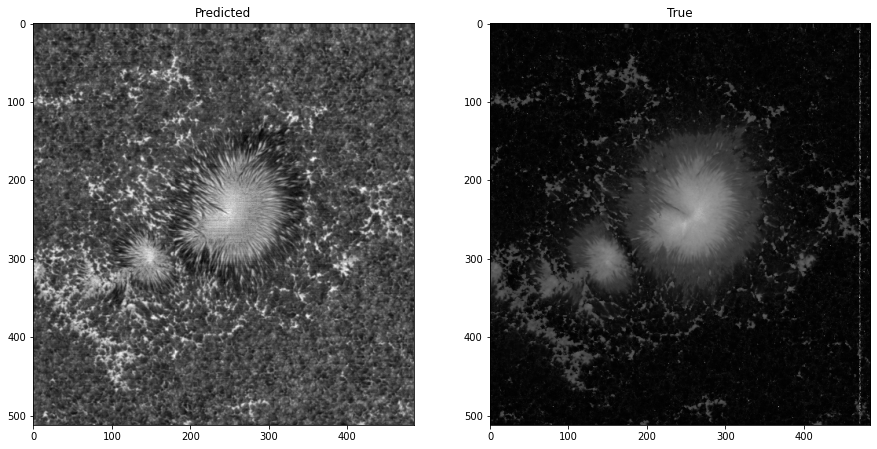

In [9]:
def plot_spectra(pred, true):
  plt.figure(figsize=(15,15))
  plt.subplot(1, 2, 1)
  plt.imshow(pred, cmap='gray')
  plt.title('Predicted')

  plt.subplot(1, 2, 2)
  plt.imshow(true, cmap='gray')
  plt.title('True')

plot_spectra(predicted, reference[1].data)